In [2]:
# TRANSFER LEARNING FINE TUNING -  MASS CALC BENIGN MALIGN NORMAL CLASSIFIER USING MAMMOGRAM PATCHES IN CBIS-DDSM
!pip install matplotlib
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from tensorflow.keras.utils import np_utils
#%matplotlib inline
tensorflow.keras.backend.set_image_data_format('channels_last')
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.layers import ReLU
import time

     ---------------------------------------- 7.2/7.2 MB 6.2 MB/s eta 0:00:00
     -------------------------------------- 160.2/160.2 kB 1.4 MB/s eta 0:00:00
     -------------------------------------- 55.4/55.4 kB 717.0 kB/s eta 0:00:00
     -------------------------------------- 965.4/965.4 kB 6.8 MB/s eta 0:00:00


Matplotlib is building the font cache; this may take a moment.


In [5]:
# Load NASNetLarge TL model
IMG_SIZE=331
from tensorflow.keras.applications.nasnet import NASNetLarge

base_model=NASNetLarge(weights='imagenet',include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512)(x)
x=ReLU()(x)
x=Dropout(0.5)(x)
x=Dense(128)(x) 
x=ReLU()(x)
preds=Dense(5,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)

model.load_weights("mas_cal_ben_mal_class_nasnet50_weights_v004.h5")
batch_size=6

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('CBIS_DDSM_PATCHES_01/test', 
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=False)


# Ref: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045 accessed on 5 Feb 2020
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, matthews_corrcoef


Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
ras=roc_auc_score(test_generator.classes, Y_pred,multi_class='ovr')


print('Confusion Matrix:')
print(confusion_matrix(test_generator.classes, y_pred))
print('Accuracy:', accuracy_score(test_generator.classes, y_pred))
print('ROC AUC score:', ras)


Found 645 images belonging to 5 classes.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13260\1088630558.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion Matrix:
[[ 73  30   7  13   6]
 [ 35  63   8  19   4]
 [  1   0  67  59   2]
 [  1   3  12 113   0]
 [  1   0   0   3 125]]
Accuracy: 0.6837209302325581
ROC AUC score: 0.9276936482182562


In [16]:
# Compute ROC curve and ROC area for each class
# y_test: test target   y_score: test prediction

#!pip install --upgrade tensorflow --user

import sklearn

fpr = dict()
tpr = dict()
roc_auc = dict()
#y_test=test_generator.classes

# Binarize the output
y_test = sklearn.preprocessing.label_binarize(test_generator.classes, classes=[0, 1, 2, 3, 4])

y_score=Y_pred
n_classes=5

for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

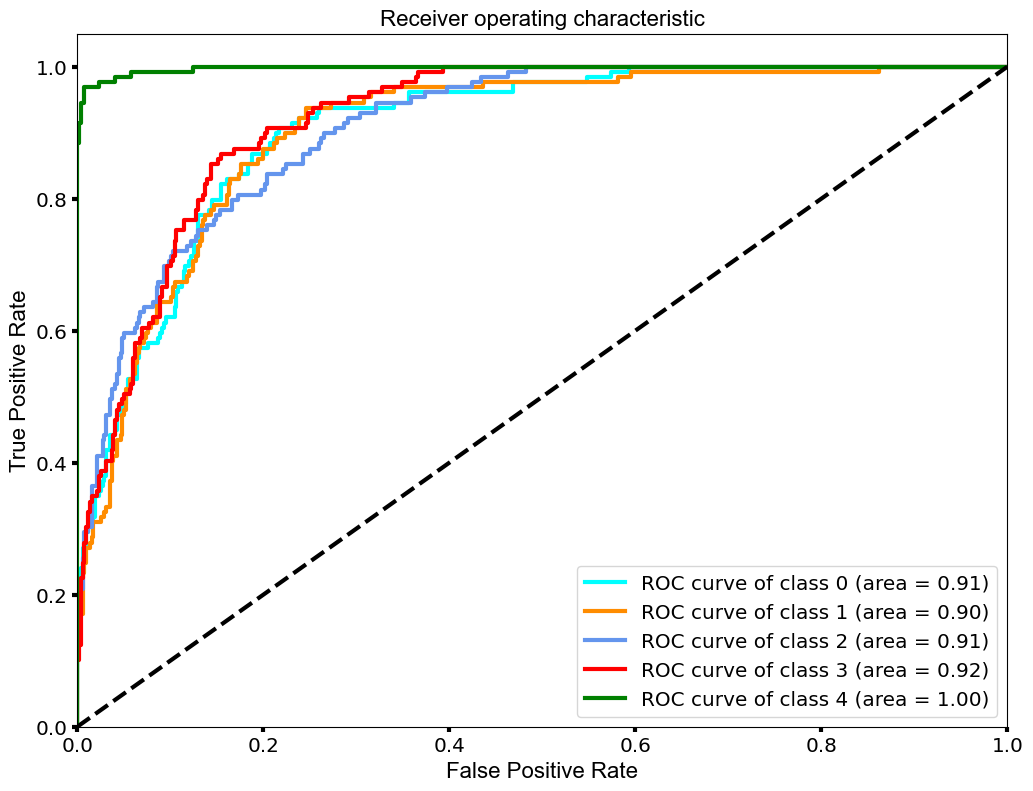

In [19]:
 from itertools import cycle

lw = 3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = sklearn.metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=[12, 9])
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )



font = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.tick_params(labelcolor='k', labelsize='x-large', width=3)    


plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontdict=font)
plt.ylabel("True Positive Rate", fontdict=font)
plt.title("Receiver operating characteristic", fontdict=font)
plt.legend(loc="lower right",fontsize='x-large')
plt.show()